# Application of FRANKEN-Z to Real Data

This notebook demonstrates an application of FRANKEN-Z to S16A **Hyper Suprime-Cam (HSC) Subaru Strategic Program (SSP) survey data**. As the training data includes $\sim\!400,000$ objects that have been **inhomogeneously sampled** (cobbled together from various surveys) with **varying errors** (stochastic backgrounds) and **depths** (collected from wide, deep, and ultra-deep fields) along with **multiple flux measurements** (PSF, Cmodel, and fiber/aperture quantities) and **randomly censored data** (from failed extractions and missing coverage), modeling these data provides many new challenges and opportunities.

This fourth notebook outlines an applications to HSC COSMOS observations observed in different seeing conditions to quantify how performance changes as a function of seeing.

# Setup

Let's initialize the environment.

In [1]:
import sys # system commands
import gc # garbage memory collection
from scipy import stats # statistics
from scipy import special # special functions
from astropy.io import fits # reading fits files

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Importing FRANKEN-Z config files...

In [2]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])
Nf=filt.NFILTER

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color

Importing HSC training data...

In [3]:
# load observed data
hdul=fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/catalogs/hsc_s16a_combined_specz_highq_clean_errsim_train_v1.fits')
data=hdul[1].data
print 'Training objects:',len(data)

Training objects: 373432


In [4]:
aphot=10**(-0.4*c_[data['a_g'],data['a_r'],data['a_i'],data['a_z'],data['a_y']])
print 'Median correction:',median(aphot,axis=0)

Median correction: [ 0.94042301  0.95740581  0.96941328  0.97632635  0.97976404]


In [5]:
flux_cmodel=c_[data['gcmodel_flux'],data['rcmodel_flux'],data['icmodel_flux'],data['zcmodel_flux'],data['ycmodel_flux']]*aphot
err_cmodel=c_[data['gcmodel_flux_err'],data['rcmodel_flux_err'],data['icmodel_flux_err'],
           data['zcmodel_flux_err'],data['ycmodel_flux_err']]*aphot
err_cmodel_wide=c_[data['gcmodel_flux_err_wide'],data['rcmodel_flux_err_wide'],data['icmodel_flux_err_wide'],
                data['zcmodel_flux_err_wide'],data['ycmodel_flux_err_wide']]*aphot
mask_cmodel=(err_cmodel>0.)&isfinite(err_cmodel)
print 'Objects with missing values:',(mask_cmodel.sum(axis=1)<Nf).sum()

Objects with missing values: 0


In [6]:
flux_afterburner=c_[data['gparent_flux_convolved_2_1'],data['rparent_flux_convolved_2_1'],data['iparent_flux_convolved_2_1'],
                   data['zparent_flux_convolved_2_1'],data['yparent_flux_convolved_2_1']]*aphot
err_afterburner=c_[data['gflux_aperture15_err'],data['rflux_aperture15_err'],data['iflux_aperture15_err'],
                   data['zflux_aperture15_err'],data['yflux_aperture15_err']]*aphot

mask_afterburner=(err_afterburner>0.)&isfinite(err_afterburner)
print 'Objects with missing values:',(mask_afterburner.sum(axis=1)<Nf).sum()

Objects with missing values: 3


In [7]:
z,ze,zt,zs=data['redshift'],data['redshift_err'],data['redshift_type'],data['redshift_source']
ze[ze<0]=0.

In [8]:
Ntrain=len(flux_afterburner) # number of objects
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(err_cmodel_wide,axis=0) # "background" skynoise (used for consistent mappings)
mag_cmodel,magerr_cmodel=fz.asinh_mag_map(flux_cmodel,err_cmodel_wide,skynoise,zeropoint=flux_zeropoint) # Luptitude mapping
mag_afterburner,magerr_afterburner=fz.asinh_mag_map(flux_afterburner,err_cmodel_wide,skynoise,zeropoint=flux_zeropoint)

In [9]:
lzidx,lzeidx=rdict.fit(log(1+z),ze/(1+z)) # discretize redshifts
magidx,mageidx=mdict.fit(mag_cmodel,magerr_cmodel) # discretize magnitudes

In [10]:
# clearing up memory
del hdul[1].data,data
for hdu in hdul:
    del hdu
del hdul

Importing HSC target data (**best/median/worst seeing**)...

In [11]:
# load observed data
seeing='worst'
data=loadtxt('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/cosmos_cat/matched_'+seeing+'_v1_ab.cat',dtype='str')
print 'Testing objects:',len(data)

Testing objects: 154447


In [12]:
aphot_test=10**(-0.4*data[:,[22,44,66,88,110]].astype('float32'))
print 'Median correction:',median(aphot_test,axis=0)

Median correction: [ 0.94516009  0.96082073  0.97187972  0.97824156  0.98140383]


In [13]:
flux_afterburner_test=(data[:,[9,31,53,75,97]].astype('float32'))*aphot_test*1e29
err_afterburner_test=(data[:,[10,32,54,76,98]].astype('float32'))*aphot_test*1e29
mask_afterburner_test=(err_afterburner_test>0.)&isfinite(err_afterburner_test)
mask_afterburner_test*=(flux_afterburner_test!=0.)&isfinite(flux_afterburner_test)
print 'Objects with missing values:',(mask_afterburner_test.sum(axis=1)<Nf).sum()

Objects with missing values: 1187


Cleaning data (removing objects with no measured fluxes):

In [14]:
flux_sel=mask_afterburner_test.sum(axis=1)>0
print 'Objects with no flux measurements:',(flux_sel==False).sum()

Objects with no flux measurements: 0


In [15]:
Nobs=flux_sel.sum() # number of objects
mag_afterburner_test,magerr_afterburner_test=fz.asinh_mag_map(flux_afterburner_test,err_afterburner_test,
                                                              skynoise,zeropoint=flux_zeropoint)
magidx_test,mageidx_test=mdict.fit(mag_afterburner_test,magerr_afterburner_test) # discretize magnitudes

In [16]:
# clearing up memory
del data

# Fitting Data

Let's initialize our fluxes, errors, and masks along with our WINBET instances.

In [17]:
# redefining fluxes

p1,v1,m1=flux_afterburner,square(err_afterburner),mask_afterburner # training
p1[m1==False],v1[m1==False]=1.,1. # filling in missing values with arbitrary values
p2,v2,m2=flux_afterburner_test,square(err_afterburner_test),mask_afterburner_test # testing (observed)
p2[m2==False],v2[m2==False]=1.,1. # filling in missing values with arbitrary values
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

del flux_afterburner,err_afterburner,mask_afterburner
del flux_afterburner_test,err_afterburner_test,mask_afterburner_test

In [18]:
N_members=25 # number of trees/Monte Carlo realizations used for nearest-neighbor search
N_neighbors=10 # number of neighbors selected at each iteration

winbet_train=fz.WINBET(Ntrees=N_members,Nleaf=N_neighbors)
winbet_test=fz.WINBET(Ntrees=N_members,Nleaf=N_neighbors)
if (m1==False).sum()>0:
    winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
else:
    winbet_train=None
if (m2==False).sum()>0:
    winbet_test.train(p2[flux_sel],v2[flux_sel],m2[flux_sel],mag2[flux_sel],mage2[flux_sel],mdict)
else:
    winbet_test=None

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

With this all set, let's fit the data!

In [19]:
frankenz=fz.FRANKENZ(N_members=N_members,n_neighbors=N_neighbors)
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,
                                                            p2[flux_sel],e2[flux_sel],m2[flux_sel],
                                                            impute_train=winbet_train,impute_test=winbet_test)

0: 0 0 500 1000 1: 0 0 500 1000 2: 0 0 500 1000 3: 0 0 500 1000 4: 0 0 500 1000 5: 0 0 500 1000 6: 0 0 500 1000 7: 0 0 500 1000 8: 0 0 500 1000 9: 0 0 500 1000 10: 0 0 500 1000 11: 0 0 500 1000 12: 0 0 500 1000 13: 0 0 500 1000 14: 0 0 500 1000 15: 0 0 500 1000 16: 0 0 500 1000 17: 0 0 500 1000 18: 0 0 500 1000 19: 0 0 500 1000 20: 0 0 500 1000 21: 0 0 500 1000 22: 0 0 500 1000 23: 0 0 500 1000 24: 0 0 500 1000 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 done!


## Generating Redshift PDFs

In [20]:
# generate redshifts
model_llmin=empty(Nobs,dtype='float32') # min(ln-likelihood)
lzpdf=empty((Nobs,rdict.Nz),dtype='float32') # ln(1+z) PDF
zpdf=empty((Nobs,rdict.Nz_out),dtype='float32') # z PDF
model_levidence=empty(Nobs,dtype='float32') # -2ln(evidence)

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx[midx],lzeidx[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]
    
# compute Ntype and Ptype
model_Ntype=zeros((Nobs,3),dtype='float32')
model_Ptype=zeros((Nobs,3),dtype='float32')

for i in xrange(Nobs):
    if i%5000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    ztypes=zt[midx]-1
    like=exp(-0.5*(ll-model_llmin[i]))
    like/=like.sum()
    for j in xrange(Nm):
        model_Ntype[i][ztypes[j]]+=1
        model_Ptype[i][ztypes[j]]+=like[j]

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 

In [21]:
model_sel=arange(len(p2))[flux_sel]
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out) # resample from ln(1+z) to z space
del lzpdf
gc.collect()

cols=fits.ColDefs([
        fits.Column(name='model_sel',format='J',array=model_sel),
        fits.Column(name='model_llmin',format='E',array=model_llmin),
        fits.Column(name='model_levidence',format='E',array=model_levidence),
        fits.Column(name='model_Ntype',format='3E',array=model_Ntype),
        fits.Column(name='model_Ptype',format='3E',array=model_Ptype),
        fits.Column(name='zpdf',format='601E',array=zpdf)
        ])
tbhdu=fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('/Users/Josh/Dropbox/HSC/HSC_photoz/test_16a/hsc_photoz_s16a_cosmos_'+seeing+'_zpdf.fits',clobber=True)
del cols,tbhdu

Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 done!


## Redshift Tests

Since we don't have the "true" results, we only can quantify broad features such as, e.g., photo-z dispersion about the median solution, the $dN/dz$ distribution, etc. Let's start with the $dN/dz$ solution.

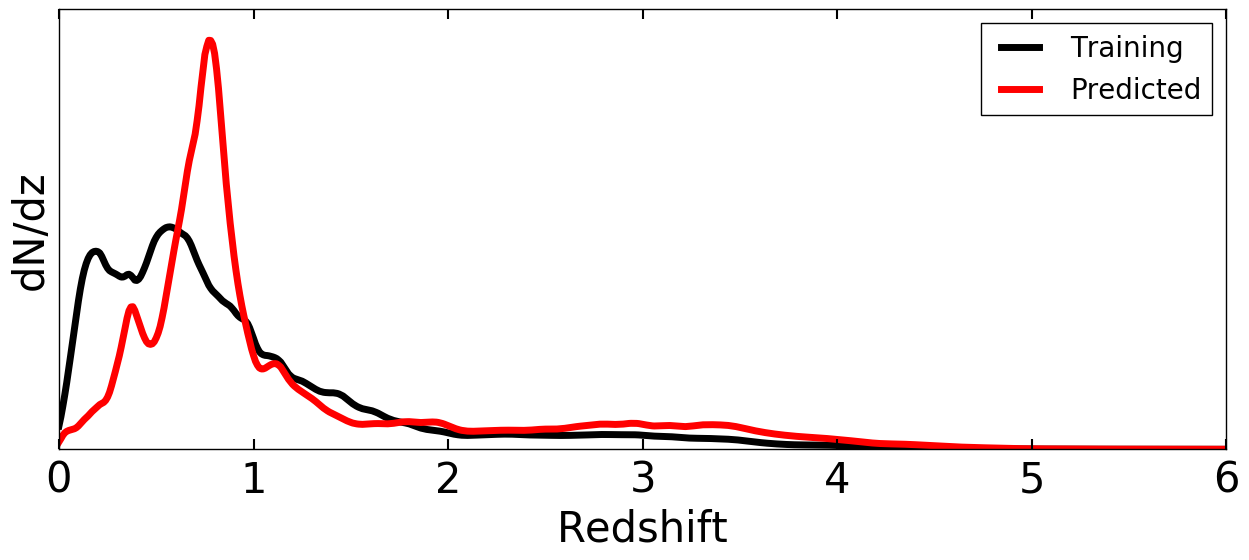

In [22]:
figure(figsize=(14,6))

# training
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,ones(Ntrain),rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Training')

nz_stack=nansum(zpdf,axis=0)/Nobs
plot(rdict.zgrid_out,nz_stack,lw=5,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

That broadly looks reasonable. Now let's examine the error properties as a function of magnitude. Plotted below is the PDF dispersion about the median as a function of Cmodel magnitude.

In [23]:
# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 done!


0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 Computing PDF quantities...0 done!


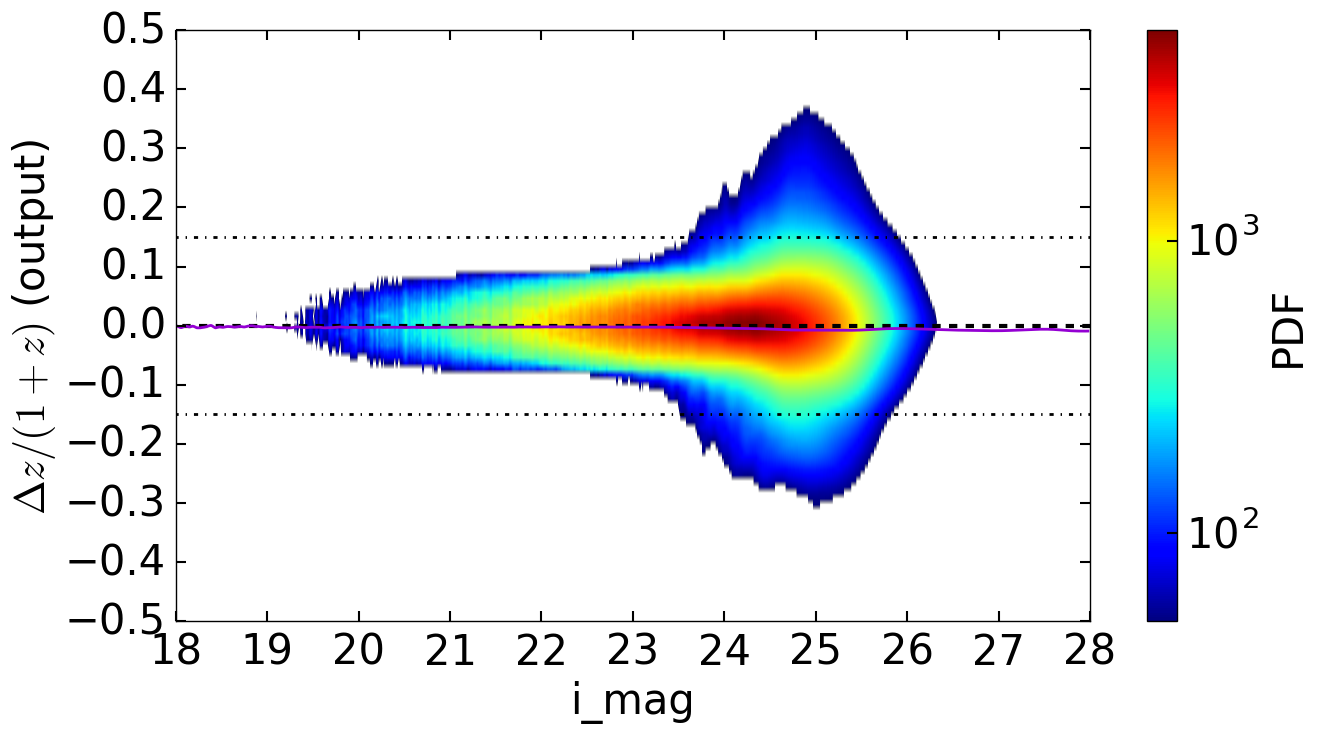

In [24]:
figure(figsize=(14,8))
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,zpoints[1],
                                          magidx_test[:,2][model_sel],mageidx_test[:,2][model_sel],
                                          mdict,[18,28,1.],'i_mag',
                                          sel=m2[:,2][model_sel],boxcar=10)

Since we're using a heterogeneous sample, it's also useful to check how well we're performing on each given redshift type. The distribution as a function of magnitude and performance in several $p_t$ bins are shown below.

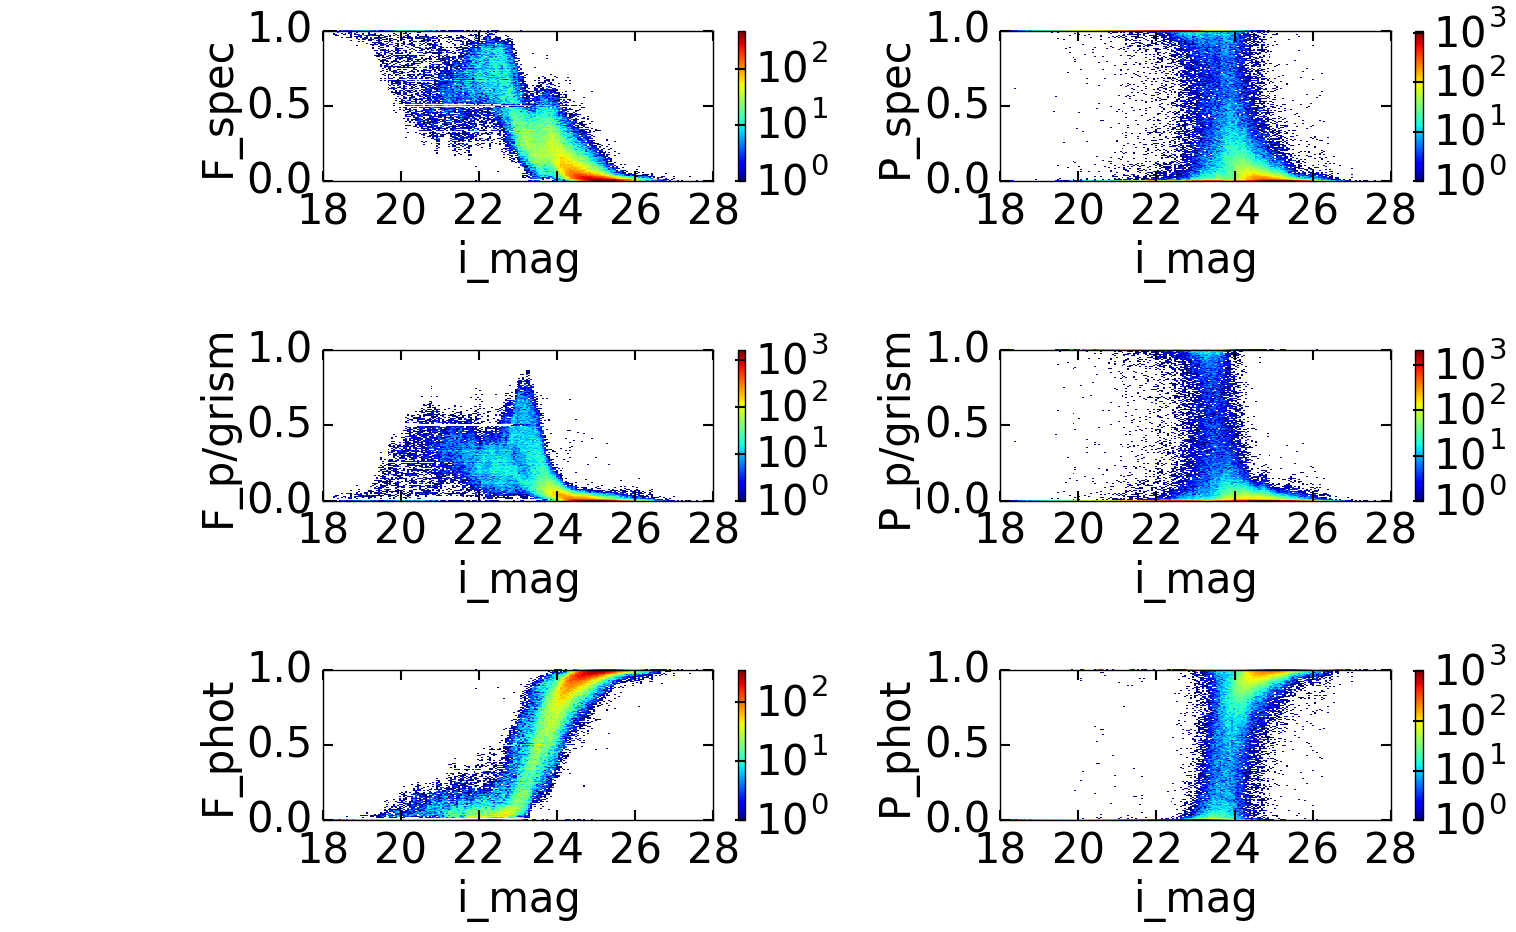

In [25]:
figure(figsize=(14,10))
subplot(3,2,1)
h=hist2d(mag_afterburner_test[:,2][model_sel],model_Ntype[:,0]/model_Ntype.sum(axis=1),
         bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag')
ylabel('F_spec')
tight_layout()
subplot(3,2,2)
h=hist2d(mag_afterburner_test[:,2][model_sel],model_Ptype[:,0]/model_Ptype.sum(axis=1),
         bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag')
ylabel('P_spec')
tight_layout()
subplot(3,2,3)
h=hist2d(mag_afterburner_test[:,2][model_sel],model_Ntype[:,1]/model_Ntype.sum(axis=1),
         bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag')
ylabel('F_p/grism')
tight_layout()
subplot(3,2,4)
h=hist2d(mag_afterburner_test[:,2][model_sel],model_Ptype[:,1]/model_Ptype.sum(axis=1),
         bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag')
ylabel('P_p/grism')
tight_layout()
subplot(3,2,5)
h=hist2d(mag_afterburner_test[:,2][model_sel],model_Ntype[:,2]/model_Ntype.sum(axis=1),
         bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag')
ylabel('F_phot')
tight_layout()
subplot(3,2,6)
h=hist2d(mag_afterburner_test[:,2][model_sel],model_Ptype[:,2]/model_Ptype.sum(axis=1),
         bins=[arange(10,30,0.05),linspace(0,1,200)],norm=matplotlib.colors.LogNorm(),cmin=1)
colorbar()
xlim([18,28])
ylim([0,1])
yticks([0,0.5,1.])
xlabel('i_mag')
ylabel('P_phot')
tight_layout()

As we expect, photo-z's tend to dominate the neighbors and likelihood fraction at faint magnitudes, with a sharp transition between 22nd and 24th mag.

Assuming our spec-z and grism-z based predictions are "robust", we can use $f_t$ and $p_t$ to give us some proxy into the error properties of our sample as we transition away from "confident" redshifts into more speculative regions of color-magnitude space.

0 5000 10000 15000 20000 25000 30000 35000 40000 45000 Computing PDF quantities...0 done!
0 5000 10000 15000 Computing PDF quantities...0 done!
0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 Computing PDF quantities...0 done!


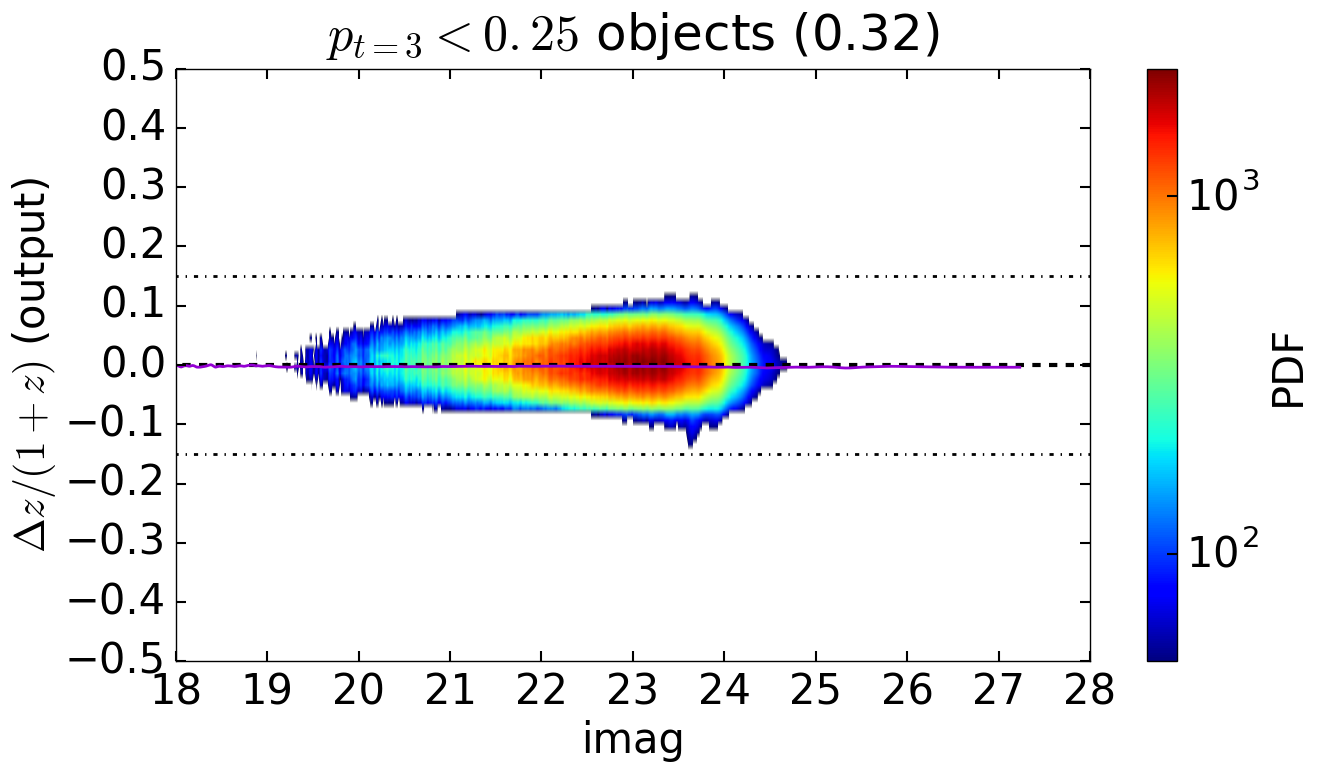

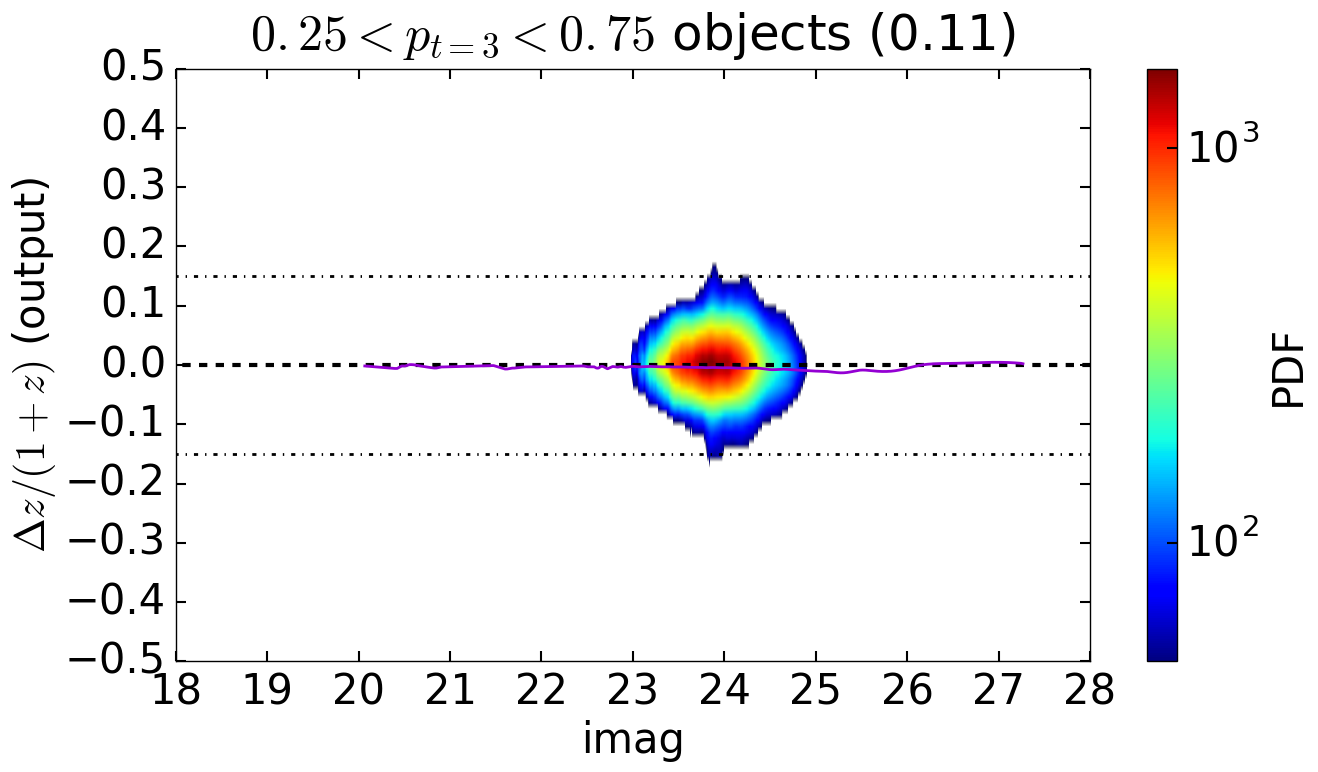

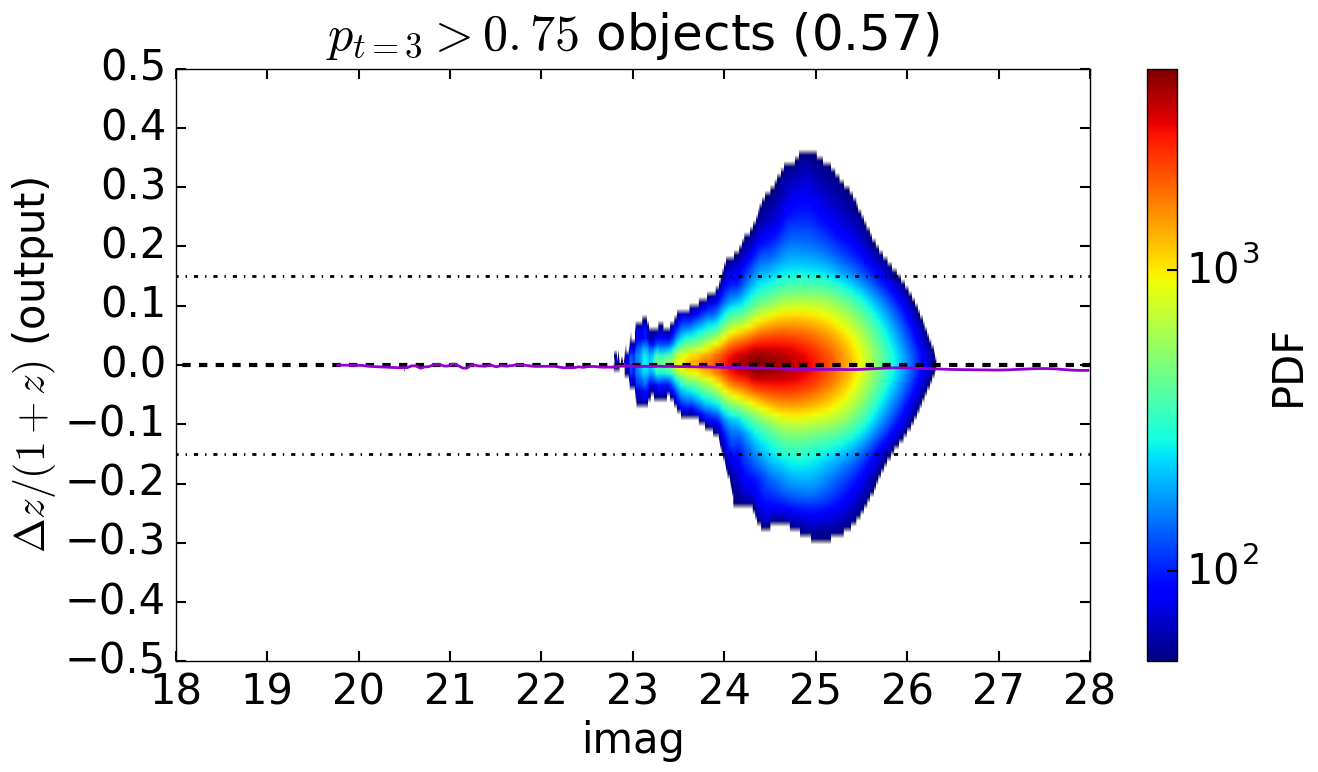

In [26]:
figure(figsize=(14,8))
sel=model_Ptype[:,2]<0.25
fsel=round(sel.sum()*1.0/Nobs,2)
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,zpoints[1],
                                          magidx_test[:,2][model_sel],mageidx_test[:,2][model_sel],
                                          mdict,[18,28,1.],'imag',
                                          sel=sel&m2[:,2][model_sel],boxcar=10)
title('$p_{t=3}<0.25$ objects ('+str(fsel)+')',y=1.02)

figure(figsize=(14,8))
sel=(model_Ptype[:,2]>0.25)&(model_Ptype[:,2]<0.75)
fsel=round(sel.sum()*1.0/Nobs,2)
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,zpoints[1],
                                          magidx_test[:,2][model_sel],mageidx_test[:,2][model_sel],
                                          mdict,[18,28,1.],'imag',
                                          sel=sel&m2[:,2][model_sel],boxcar=10)
title('$0.25<p_{t=3}<0.75$ objects ('+str(fsel)+')',y=1.02)

figure(figsize=(14,8))
sel=(model_Ptype[:,2]>0.75)
fsel=round(sel.sum()*1.0/Nobs,2)
mzstack,mzprob,mzpoints=fz.plot_dpdfstack(zpdf,rdict.zgrid_out,zpoints[1],
                                          magidx_test[:,2][model_sel],mageidx_test[:,2][model_sel],
                                          mdict,[18,28,1.],'imag',
                                          sel=sel&m2[:,2][model_sel],boxcar=10)
title('$p_{t=3}>0.75$ objects ('+str(fsel)+')',y=1.02)

As expected, these show that our spec-z/grism-z likelihood proportion per object is a rough proxy for magnitude, with predictions for fainter objects relying on larger fractions of COSMOS/3DHST photo-z's.